In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

## 1. OrderLog + TradeLog

In [2]:
date = 20200410

readPath = r'\\192.168.10.30\Kevin_zhenyu\rawData'
mdOrderLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdOrderLog***.csv'))[-1]
mdTradeLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdTradeLog***.csv'))[-1]
    
mdOrderLog = pd.read_csv(mdOrderLogPath)
mdOrderLog['OrderType'] = mdOrderLog['OrderType'].astype(str)
mdOrderLog = mdOrderLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'Side',
                             'OrderType', 'Price', 'OrderQty']]
    
mdTradeLog = pd.read_csv(mdTradeLogPath)
mdTradeLog['ExecType'] = mdTradeLog['ExecType'].astype(str)
mdTradeLog['volumeThisUpdate'] = np.where(mdTradeLog['ExecType'] == 'F', mdTradeLog['TradeQty'], 0)
mdTradeLog['cum_volume'] = mdTradeLog.groupby(['SecurityID'])['volumeThisUpdate'].cumsum()
mdTradeLog = mdTradeLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'cum_volume',
                             'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney', 'BidApplSeqNum', 'OfferApplSeqNum']]

mdMsgData = pd.concat([mdOrderLog, mdTradeLog], sort=False)
del mdOrderLog
del mdTradeLog
mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)
mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].ffill()
mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].backfill()
mdMsgData['ExecType'] = mdMsgData['ExecType'].fillna('2')
mdMsgData['TradeQty'] = mdMsgData['TradeQty'].fillna(0)
    
saveCols = ['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'cum_volume', 'ApplSeqNum', 
                'Side', 'OrderType', 'Price', 'OrderQty', 'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney',
                'BidApplSeqNum', 'OfferApplSeqNum']
rawMsgDataSZ = mdMsgData[saveCols]
del mdMsgData
orderDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '2'][['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'OrderQty', 'Price', 'cum_volume']].reset_index(drop=True)
orderDataSZ['updateType'] = 0
tradeDataSZ = pd.concat([rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'BidApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume']],
                             rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume']]], sort=False)
tradeDataSZ['ApplSeqNum'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), tradeDataSZ['OfferApplSeqNum'], tradeDataSZ['BidApplSeqNum'])
tradeDataSZ['Side'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), 2, 1)
tradeDataSZ = tradeDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradePrice', 'TradeQty', 'cum_volume']]
tradeDataSZ['updateType'] = 4
cancelDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '4'][['SecurityID', 'BidApplSeqNum', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume']].reset_index(drop=True)
cancelDataSZ['ApplSeqNum'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, cancelDataSZ['OfferApplSeqNum'], cancelDataSZ['BidApplSeqNum'])
cancelDataSZ['Side'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, 2, 1)
cancelDataSZ = cancelDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradeQty', 'cum_volume']]
cancelDataSZ['updateType'] = 3

msgDataSZ = pd.concat([orderDataSZ, tradeDataSZ, cancelDataSZ], sort=False)
del orderDataSZ
del tradeDataSZ
del cancelDataSZ
del rawMsgDataSZ
msgDataSZ = msgDataSZ.sort_values(by=['SecurityID', 'ApplSeqNum', 'sequenceNo']).reset_index(drop=True)
    
msgDataSZ['TradePrice'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradePrice'], 0)
msgDataSZ['TradePrice'] = msgDataSZ['TradePrice'].astype('int64')
msgDataSZ['TradeQty'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradeQty'], 0)
msgDataSZ['TradeQty'] = msgDataSZ['TradeQty'].astype('int64')
msgDataSZ['secid'] = msgDataSZ['SecurityID'] + 2000000
assert(msgDataSZ['ApplSeqNum'].max() < 1e8)
msgDataSZ['StockSeqNum'] = msgDataSZ['SecurityID']*1e8 + msgDataSZ['ApplSeqNum']
msgDataSZ['date'] = date
msgDataSZ['startVolume'] = msgDataSZ.groupby(['StockSeqNum'])['cum_volume'].transform('first')

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
check1 = msgDataSZ[msgDataSZ["SecurityID"] == 757]
def getTuple(x):
    return tuple(i for i in x)
tp = check1.groupby(['StockSeqNum'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
tp = tp.rename(columns={'updateType': 'updateTypeLs'})
check1 = pd.merge(check1, tp, on="StockSeqNum")
tp = check1.groupby(['StockSeqNum'])['TradePrice'].apply(lambda x: getTuple(x)).reset_index()
tp = tp.rename(columns={'TradePrice': 'TradePriceLs'})
check1 = pd.merge(check1, tp, on="StockSeqNum")
tp = check1.groupby(['StockSeqNum'])['TradeQty'].apply(lambda x: getTuple(x)).reset_index()
tp = tp.rename(columns={'TradeQty': 'TradeQtyLs'})
check1 = pd.merge(check1, tp, on="StockSeqNum")
check1.head()

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,startVolume,updateTypeLs,TradePriceLs,TradeQtyLs
0,757,822.0,1586481307798457,369039,1.0,400.0,49600.0,0.0,0,0,0,2000757,7.570000e+10,20200410,0.0,"(0, 3)","(0, 0)","(0, 0)"
1,757,822.0,1586481350038385,1025388,1.0,NaN,NaN,0.0,3,0,0,2000757,7.570000e+10,20200410,0.0,"(0, 3)","(0, 0)","(0, 0)"
2,757,1874.0,1586481307833694,373413,2.0,2400.0,48400.0,0.0,0,0,0,2000757,7.570000e+10,20200410,0.0,"(0, 3)","(0, 0)","(0, 0)"
3,757,1874.0,1586483076570010,20774572,2.0,NaN,NaN,8361800.0,3,0,0,2000757,7.570000e+10,20200410,0.0,"(0, 3)","(0, 0)","(0, 0)"
4,757,3343.0,1586481307876124,379856,2.0,2800.0,49000.0,0.0,0,0,0,2000757,7.570000e+10,20200410,0.0,"(0, 3)","(0, 0)","(0, 0)"


## 2. OrderLog + Snapshot

In [5]:
date = 20200410
readPath = r'\\192.168.10.30\Kevin_zhenyu\rawData'
mdOrderLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdOrderLog***.csv'))[-1]
mdssPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdLog_SZ***.csv'))[-1]
mdOrderLog = pd.read_csv(mdOrderLogPath).loc[:, ["clockAtArrival", "sequenceNo", "TransactTime",
                                                 "ApplSeqNum", "SecurityID", "Side", "OrderType", "Price",
                                                 "OrderQty"]]
mdSZ = pd.read_csv(mdssPath).loc[:, ["clockAtArrival", "sequenceNo", "StockID",
                                      "time", "cum_volume", "cum_amount", "close",
                                     "bid1p", "bid1q","ask1p", "ask1q", "openPrice"]]
sl1 = mdOrderLog["SecurityID"].unique()
sl2 = mdSZ["StockID"].unique()
sl = list(set(sl1) & set(sl2))
mdOrderLog = mdOrderLog[mdOrderLog["SecurityID"].isin(sl)]
mdSZ = mdSZ[mdSZ["StockID"].isin(sl)]
display(mdSZ.head())
display(mdOrderLog.head())

,clockAtArrival,sequenceNo,StockID,time,cum_volume,cum_amount,close,bid1p,bid1q,ask1p,ask1q,openPrice
0,1586478875218021,1841,2,08:34:27.000,0,0.0,0.0,0.0,0,0.0,0,0.0
1,1586478875218029,1842,8,08:34:27.000,0,0.0,0.0,0.0,0,0.0,0,0.0
2,1586478875218033,1843,12,08:34:27.000,0,0.0,0.0,0.0,0,0.0,0,0.0
3,1586478875218037,1844,19,08:34:27.000,0,0.0,0.0,0.0,0,0.0,0,0.0
4,1586478875218068,1845,23,08:34:27.000,0,0.0,0.0,0.0,0,0.0,0,0.0


,clockAtArrival,sequenceNo,TransactTime,ApplSeqNum,SecurityID,Side,OrderType,Price,OrderQty
0,1586481307778851,365155,91500000,1,889,1,2,144000,588900
1,1586481307778856,365156,91500000,2,2537,1,2,74500,1000000
2,1586481307778865,365157,91500000,3,2537,1,2,74500,996800
3,1586481307778867,365158,91500000,4,2537,1,2,74500,1000000
4,1586481307778868,365159,91500000,5,2537,1,2,74500,990600


In [11]:
mdSZ["time"] = mdSZ["time"].apply(lambda x: int((x.replace(':', "")).replace(".", "")))
mdSZ = mdSZ.rename(columns={"StockID":"SecurityID", "time":"TransactTime"})
s1 = pd.concat([mdSZ[mdSZ["SecurityID"] == 757], mdOrderLog[mdOrderLog["SecurityID"] == 757]]).sort_values(by="sequenceNo")
display(s1[s1["TransactTime"]>=94500000].head())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,ApplSeqNum,OrderQty,OrderType,Price,SecurityID,Side,TransactTime,ask1p,ask1q,bid1p,bid1q,clockAtArrival,close,cum_amount,cum_volume,openPrice,sequenceNo
1560190,NaN,NaN,NaN,NaN,757,NaN,94500000,4.64,60700.0,4.63,8000.0,1586483108403798,4.63,38905640.0,8388400.0,4.58,21316942
1560222,NaN,NaN,NaN,NaN,757,NaN,94500000,4.64,60700.0,4.63,8000.0,1586483108414643,4.63,38905640.0,8388400.0,4.58,21317945
9146853,3915604.0,5000.0,2,46400.0,757,1.0,94500770,NaN,NaN,NaN,NaN,1586483108524955,NaN,NaN,NaN,NaN,21321583
9159994,3921352.0,600.0,2,46400.0,757,2.0,94501940,NaN,NaN,NaN,NaN,1586483109695864,NaN,NaN,NaN,NaN,21357193
9160111,3921398.0,4500.0,2,46900.0,757,2.0,94501950,NaN,NaN,NaN,NaN,1586483109713614,NaN,NaN,NaN,NaN,21357431


## 3. SZ000757 0410 午后异动拉升

### 3.1 全天价格变化

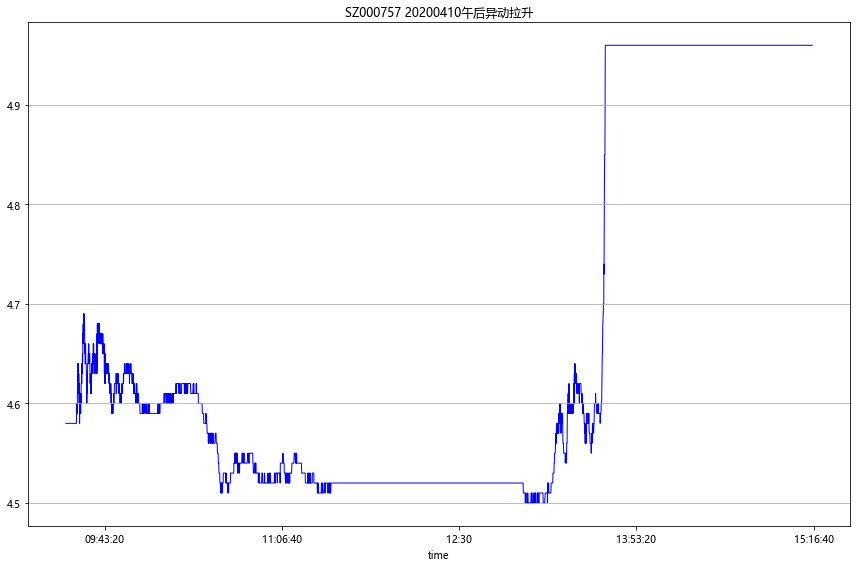

In [26]:
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from pylab import mpl
from skimage.transform import resize
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False

df1 = mdSZ[(mdSZ["SecurityID"] == 757) & (mdSZ["close"] != 0)]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pd.to_datetime(df1["TransactTime"].astype(str).str[:-3].str.zfill(6), format='%H%M%S').dt.time, df1["close"], color='blue', alpha=2, linewidth=1, zorder=1)
# ax.set_xticks(ax.get_xticks()[::5])
ax.set_title("SZ000757 20200410午后异动拉升")
ax.grid(axis='y')
fig.tight_layout()
plt.show()